In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [130]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
def use_svg_display():
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
set_figsize()

In [135]:
sheets_jjfz = pd.ExcelFile('./data/经济发展度1993-2022.xlsx').sheet_names
sheets_jjfz

['城市GDP', '人均GDP', '第三产业增加值', '社会消费品零售总额', '年末户籍人口']

In [136]:
# ExcelFile.parse(sheet_name=0, header=0, names=None, index_col=None, usecols=None, converters=None,
#                 true_values=None, false_values=None, skiprows=None, nrows=None, na_values=None,
#                 parse_dates=False, date_parser=_NoDefault.no_default, date_format=None, thousands=None,
#                 comment=None, skipfooter=0, dtype_backend=_NoDefault.no_default, **kwds)
# https://pandas.pydata.org/docs/reference/api/pandas.ExcelFile.parse.html

GDP = pd.ExcelFile('./data/经济发展度1993-2022.xlsx').parse(sheet_name='城市GDP', index_col=0, skiprows=3, skipfooter=2)
# GDP


Index([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022],
      dtype='int64')
30


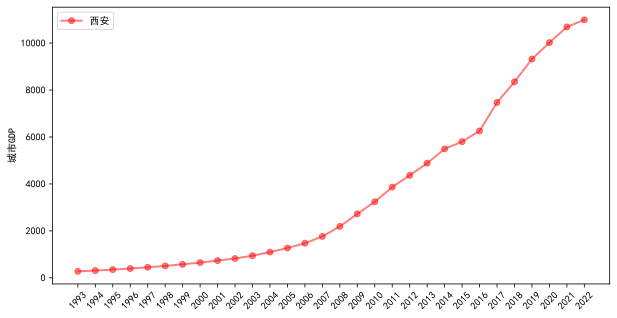

In [137]:
city='西安'   #'北京' #'西安'
metric='城市GDP'    # '城市GDP', '人均GDP', '第三产业增加值', '社会消费品零售总额', '年末户籍人口'

plt.rc('font',family='SimHei')  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
set_figsize((10, 5))
# plt.plot(GDP.iloc[0, :].values[::-1], 'o-', linewidth=2, color='r', label='GDP', alpha=0.5)
plt.plot(GDP.loc[city, :].values[::-1], 'o-', linewidth=2, color='r', label=city, alpha=0.5)
# GDP = GDP.iloc[0:1, :]
# print(GDP)
# plt.plot(GDP, 'o-', linewidth=2, alpha=0.5)
# plt.xlabel('xlabel')
plt.ylabel(metric)
print(GDP.columns[::-1])
print(len(GDP.columns))
# print(GDP.info())
# print(GDP.describe())
# plt.xticks(ticks=range(len(GDP.columns[0:])), labels=GDP.columns[0:][::-1], rotation=45)
plt.xticks(ticks=range(len(GDP.columns)), labels=GDP.columns[::-1], rotation=45)
plt.legend()
plt.show()


In [138]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

# 获取数据
data = GDP.iloc[0, 1:].values[::-1]

# 将数据归一化到 [0,1] 区间
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))

# 定义一个函数，将时间序列数据转化为监督学习问题
def to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 使用过去的 3 个观测值来预测下一个值
n_in = 3
n_out = 1
data = to_supervised(data, n_in, n_out)

# 分割输入数据和输出数据
X, y = data.iloc[:, :n_in], data.iloc[:, n_in:]

# 定义模型
model = MLPRegressor(hidden_layer_sizes=(1000,), activation='tanh', max_iter=20000, random_state=2, tol=1e-9)

# 拟合模型
model.fit(X, y)

# 预测未来的值
predictions = model.predict(X)

# 将预测值反归一化
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# 打印出预测值
# print(predictions)

c:\Users\bjiang7\AppData\Local\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


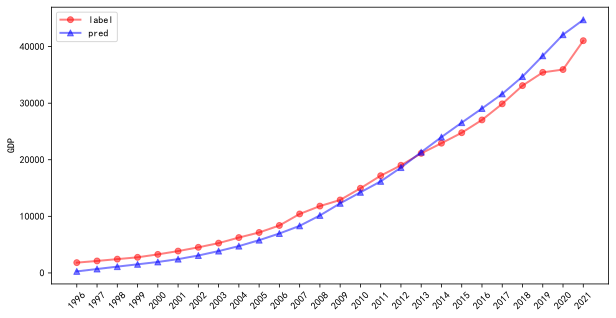

In [139]:
# plt.rc('font',family='SimHei')  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
set_figsize((10, 5))
plt.plot(GDP.iloc[0, 1:].values[::-1][3:], 'o-', linewidth=2, color='r', label='label', alpha=0.5)
plt.plot(predictions, '^-', linewidth=2, color='b', label='pred', alpha=0.5)
# plt.xlabel('xlabel')
plt.ylabel('GDP')
plt.xticks(range(len(GDP.columns[1:][3:])), GDP.columns[1:][::-1][3:], rotation=45)
plt.legend()
plt.show()

In [140]:
# 假设我们要预测的步数为 future_steps
future_steps = 30
predictions_future = []
last_n_values = list(data.iloc[-n_in:, 3]) # 注意这里是取最后n_in行的第一列
for _ in range(future_steps):
    X_pred = np.array(last_n_values).reshape(1, -1)
    y_pred = model.predict(X_pred)
    predictions_future.append(y_pred[0])
    
    # 将预测值添加到输入序列中
    last_n_values.append(y_pred[0])
    last_n_values = last_n_values[1:]
    
# 将预测值反归一化
predictions_future = scaler.inverse_transform(np.array(predictions_future).reshape(-1, 1))

# 打印出预测值
print(predictions_future)

[[ 47885.32959103]
 [ 53590.0115513 ]
 [ 61390.35767271]
 [ 69954.48597812]
 [ 79482.50629737]
 [ 90406.42104168]
 [102474.06158775]
 [115800.61374249]
 [130326.58508416]
 [145870.20959547]
 [162220.71725601]
 [179042.42790929]
 [195935.01611834]
 [212466.24135863]
 [228210.17240421]
 [242803.08683405]
 [255977.70369084]
 [267581.3518836 ]
 [277573.98893256]
 [286009.27991592]
 [293008.05696396]
 [298730.63014174]
 [303353.07916764]
 [307049.81087115]
 [309982.42182014]
 [312293.84455827]
 [314106.31393897]
 [315521.77960484]
 [316623.6855874 ]
 [317479.35990807]]


c:\Users\bjiang7\AppData\Local\miniconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\bjiang7\AppData\Local\miniconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\bjiang7\AppData\Local\miniconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\bjiang7\AppData\Local\miniconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\bjiang7\AppData\Local\miniconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\bjiang7\AppData\

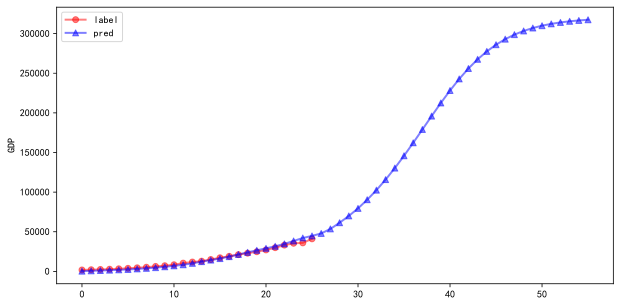

In [141]:
# plt.rc('font',family='SimHei')  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
set_figsize((10, 5))
plt.plot(GDP.iloc[0, 1:].values[::-1][3:], 'o-', linewidth=2, color='r', label='label', alpha=0.5)
plt.plot(np.vstack((predictions, predictions_future)), '^-', linewidth=2, color='b', label='pred', alpha=0.5)
# plt.xlabel('xlabel')
plt.ylabel('GDP')
# plt.xticks(range(len(GDP.columns[1:][3:])), GDP.columns[1:][::-1][3:], rotation=45)
plt.legend()
plt.show()